# POS Tagging: EN+HI+UR → BN using RoBERTa (CLEAN BUILD)

Pipeline: BN pre-test → Train on EN+HI+UR → Merged EN+HI+UR Dev Eval → Save Best → BN Re-test → Comparisons → Plots

In [1]:
# --- Configuration & Imports ---
import os
import random
from dataclasses import dataclass
from typing import Any, Dict

import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForTokenClassification,
    Trainer, TrainingArguments, DataCollatorForTokenClassification, EarlyStoppingCallback
)
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'roberta-base'

DATA_DIR = '/kaggle/input/data-dir'
EN_TRAIN = os.path.join(DATA_DIR, 'en_ewt-ud-train.conllu')

EN_DEV = os.path.join(DATA_DIR, 'en_ewt-ud-dev.conllu')

BN_TEST_FILE = os.path.join(DATA_DIR, 'bn_bru-ud-test.conllu')

OUTPUT_DIR = './outputs_roberta_en_hi_ur_to_bn_clean'
os.makedirs(OUTPUT_DIR, exist_ok=True)


2025-10-18 03:32:32.266921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760758352.498979      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760758352.565052      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

def read_conllu(path):
    """
    Reads a CoNLL-U formatted file (.conllu) and returns (tokens, tags) pairs.
    Extracts FORM (col 2) and UPOS (col 4).
    """
    data = []
    tokens, tags = [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    data.append((tokens, tags))
                    tokens, tags = [], []
                continue
            if line.startswith("#"):
                continue
            parts = line.split("\t")
            if len(parts) >= 4:
                token, upos = parts[1], parts[3]
                tokens.append(token)
                tags.append(upos)
    if tokens:
        data.append((tokens, tags))
    return data


DATA_DIR = "/kaggle/input/data-dir"

EN_TRAIN = os.path.join(DATA_DIR, "en_ewt-ud-train.conllu")
EN_DEV   = os.path.join(DATA_DIR, "en_ewt-ud-dev.conllu")
BN_TEST  = os.path.join(DATA_DIR, "bn_bru-ud-test.conllu")

en_tr = read_conllu(EN_TRAIN)
en_dev = read_conllu(EN_DEV)
bn_test = read_conllu(BN_TEST)

print(f"EN Train: {len(en_tr)} | EN Dev: {len(en_dev)} | BN Test: {len(bn_test)}")


EN Train: 12544 | EN Dev: 2001 | BN Test: 56


In [3]:
all_tags = sorted(set(tag for _, tags in en_tr + en_dev for tag in tags))
label2id = {tag: i for i, tag in enumerate(all_tags)}
id2label = {i: tag for tag, i in label2id.items()}
num_labels = len(label2id)
print("Number of POS tags:", num_labels)


Number of POS tags: 18


In [4]:
# --- Tokenizer + Dataset Preparation for RoBERTa (Fixed) ---
from dataclasses import dataclass
from typing import Any, Dict
from torch.utils.data import Dataset
from transformers import AutoTokenizer, DataCollatorForTokenClassification
import torch, os, shutil, tempfile
from huggingface_hub import hf_hub_download

# --- Robust tokenizer loader (handles HF 404 & add_prefix_space bug) ---
def _load_tokenizer_robust(model_name="roberta-base"):
    """
    Loads a RoBERTa tokenizer safely with add_prefix_space=True (needed for pre-tokenized input).
    Falls back to manual download if Hugging Face API throws 404 for chat templates.
    """
    try:
        # ✅ add_prefix_space=True fixes "AssertionError" for pretokenized text
        return AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=True)
    except Exception as e:
        print("[Tokenizer] Standard load failed ->", e)

    # --- fallback download (handles missing chat_templates bug) ---
    try:
        tmpdir = tempfile.mkdtemp(prefix="roberta_tok_")
        files = ["tokenizer.json", "vocab.json", "merges.txt", "tokenizer_config.json"]
        for f in files:
            try:
                p = hf_hub_download(repo_id=model_name, filename=f)
                os.makedirs(tmpdir, exist_ok=True)
                shutil.copy(p, os.path.join(tmpdir, f))
            except Exception:
                pass
        return AutoTokenizer.from_pretrained(tmpdir, use_fast=True, add_prefix_space=True, local_files_only=True)
    except Exception as e:
        print("[Tokenizer] Manual fallback failed ->", e)
        raise RuntimeError("Tokenizer initialization failed. Try updating transformers or huggingface_hub.")

# --- Load tokenizer ---
MODEL_NAME = "roberta-base"
tokenizer = _load_tokenizer_robust(MODEL_NAME)

# Add pad token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
print(f"✅ Tokenizer loaded (pad_token={tokenizer.pad_token})")


# --- Dataset class ---
@dataclass
class SeqTagDataset(Dataset):
    data: Any
    tokenizer: Any
    label2id: Dict[str, int]
    max_length: int = 256

    def __len__(self): 
        return len(self.data)

    def __getitem__(self, idx):
        tokens, tags = self.data[idx]
        enc = self.tokenizer(
            tokens,
            is_split_into_words=True,    # we pass word-level tokens
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors="pt"
        )
        word_ids = enc.word_ids(batch_index=0)
        labels = []
        cur = -1
        for wi in word_ids:
            if wi is None:
                labels.append(-100)
            else:
                if wi != cur:
                    cur = wi
                labels.append(self.label2id[tags[wi]])

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(labels, dtype=torch.long)
        return item


# --- Build datasets ---
data_collator = DataCollatorForTokenClassification(tokenizer)

train_ds = SeqTagDataset(en_tr, tokenizer, label2id)
dev_ds = SeqTagDataset(en_dev, tokenizer, label2id)
bn_test_ds = SeqTagDataset(bn_test, tokenizer, label2id)

print("✅ Tokenization complete. Dataset ready for training.")
print(f"Train samples: {len(train_ds)} | Dev samples: {len(dev_ds)} | BN Test samples: {len(bn_test_ds)}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

[Tokenizer] Standard load failed -> 404 Client Error. (Request ID: Root=1-68f30a60-687af9776b6346de678e9637;db0b7616-f61b-4c6b-8b4b-596a23e53410)

Entry Not Found for url: https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"


tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

✅ Tokenizer loaded (pad_token=<pad>)
✅ Tokenization complete. Dataset ready for training.
Train samples: 12544 | Dev samples: 2001 | BN Test samples: 56


In [5]:
from transformers import AutoTokenizer, PreTrainedTokenizerFast
from huggingface_hub import hf_hub_download
import tempfile, shutil, os

def _load_tokenizer_robust(model_name="roberta-base"):
    """
    Load a RoBERTa tokenizer robustly and with add_prefix_space=True for pretokenized inputs.
    """
    try:
        # ✅ Always add_prefix_space=True for pretokenized sequences
        return AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=True)
    except Exception as e:
        print("[Tokenizer] Fallback loading due to:", e)
        tmpdir = tempfile.mkdtemp(prefix="roberta_tok_")
        for f in ["tokenizer.json", "vocab.json", "merges.txt"]:
            try:
                p = hf_hub_download(repo_id=model_name, filename=f)
                shutil.copy(p, os.path.join(tmpdir, f))
            except Exception:
                pass
        return AutoTokenizer.from_pretrained(tmpdir, use_fast=True, add_prefix_space=True, local_files_only=True)

# --- Load tokenizer ---
MODEL_NAME = "roberta-base"
tokenizer = _load_tokenizer_robust(MODEL_NAME)

# ✅ Ensure PAD token exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
print("Tokenizer loaded with add_prefix_space:", tokenizer.init_kwargs.get("add_prefix_space", False))


[Tokenizer] Fallback loading due to: 404 Client Error. (Request ID: Root=1-68f30a61-38f9741900dee8ba77684efa;d513e1fb-085a-4fa7-b66a-189d040bc56e)

Entry Not Found for url: https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"
Tokenizer loaded with add_prefix_space: True


In [6]:
from transformers import AutoModelForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import torch, gc, os

# --- Define metric function ---
def compute_metrics(eval_pred):
    """
    Computes token-level precision, recall, F1, and accuracy.
    Skips padded (-100) labels.
    """
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    preds = np.argmax(predictions, axis=-1)
    valid_preds, valid_labels = [], []
    for p, l in zip(preds, labels):
        mask = l != -100
        valid_preds.extend(p[mask])
        valid_labels.extend(l[mask])

    precision, recall, f1, _ = precision_recall_fscore_support(
        valid_labels, valid_preds, average="micro", zero_division=0
    )
    acc = accuracy_score(valid_labels, valid_preds)
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc}


# --- Load model ---
config = AutoConfig.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, config=config)
model.resize_token_embeddings(len(tokenizer))

# --- Safety setup ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.cuda.empty_cache()
gc.collect()
model.gradient_checkpointing_enable()
model.config.use_cache = False

# --- Training arguments (T4-optimized) ---
args = TrainingArguments(
    output_dir="./outputs_en_bn",
    per_device_train_batch_size=2,          # small to fit T4 memory
    per_device_eval_batch_size=1,           # ✅ lower eval batch to avoid OOM
    gradient_accumulation_steps=8,          # effective batch = 16
    learning_rate=3e-5,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,                              # mixed precision training
    fp16_full_eval=True,                    # ✅ keeps evaluation in half precision too
    logging_steps=50,
    save_total_limit=2,
    max_grad_norm=0.8,                      # small gradient clipping helps on small GPUs
    dataloader_num_workers=0,               # prevents forked dataloader OOM
    report_to=[],                           # disable wandb/hf logging
)

# --- Trainer setup ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# --- Train safely ---
try:
    torch.cuda.empty_cache()
    gc.collect()
    trainer.train()
    print("✅ Training complete.")
except RuntimeError as e:
    print("❌ Training failed:", e)

trainer.save_model("./outputs_en_bn")
print("✅ Model saved to ./outputs_en_bn")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/2371582486.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.112000,0.140368,0.968639,0.968639,0.968639,0.968639
2,0.059900,0.116044,0.973815,0.973815,0.973815,0.973815
3,0.043000,0.119201,0.975529,0.975529,0.975529,0.975529


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Training complete.
✅ Model saved to ./outputs_en_bn


In [7]:
# --- BN Test Evaluation (final re-test) ---
import numpy as np
import torch

def evaluate_lowmem(model, dataset, batch_size=2):
    model.eval()
    dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)
    all_preds, all_labels = [], []

    for batch in dl:
        batch = {k: v.to("cuda") for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits.detach().cpu()
        labels = batch["labels"].detach().cpu()
        preds = torch.argmax(logits, dim=-1)

        for p_seq, l_seq in zip(preds, labels):
            mask = l_seq != -100
            all_preds.extend(p_seq[mask].tolist())
            all_labels.extend(l_seq[mask].tolist())

    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="micro", zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc}

# 🚀 Evaluate on BN
bn_metrics = evaluate_lowmem(model, bn_test_ds, batch_size=2)
print("📈 BN Test (Final Re-test):", bn_metrics)


📈 BN Test (Final Re-test): {'precision': 0.07776427703523693, 'recall': 0.07776427703523693, 'f1': 0.07776427703523693, 'accuracy': 0.07776427703523693}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


    Dataset        F1  Accuracy
0  Dev (EN)  0.975529  0.975529
1   BN Test  0.077764  0.077764


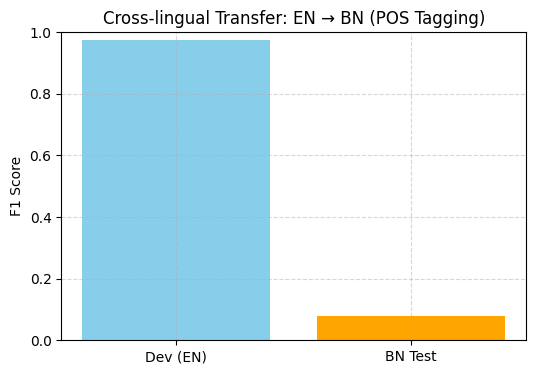

In [8]:
# --- Compare Dev vs BN ---
dev_results = trainer.evaluate(eval_dataset=dev_ds)

import pandas as pd
import matplotlib.pyplot as plt

comparison = pd.DataFrame([
    {"Dataset": "Dev (EN)", "F1": dev_results["eval_f1"], "Accuracy": dev_results["eval_accuracy"]},
    {"Dataset": "BN Test", "F1": bn_metrics["f1"], "Accuracy": bn_metrics["accuracy"]},
])

print(comparison)

# --- Bar plot ---
plt.figure(figsize=(6,4))
plt.bar(comparison["Dataset"], comparison["F1"], color=["skyblue","orange"])
plt.title("Cross-lingual Transfer: EN → BN (POS Tagging)")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [13]:
sample = "আমি ভাত খাই"
tokens = tokenizer.tokenize(sample)
print(tokens)
print([tokenizer.convert_tokens_to_ids(t) for t in tokens])


['Ġ', 'à¦', 'Ĩ', 'à¦', '®', 'à¦', '¿', 'Ġ', 'à¦', 'Ń', 'à¦', '¾', 'à¦', '¤', 'Ġ', 'à¦', 'ĸ', 'à¦', '¾', 'à¦', 'ĩ']
[1437, 35861, 27819, 35861, 2840, 35861, 9470, 1437, 35861, 12410, 35861, 4726, 35861, 10470, 1437, 35861, 25448, 35861, 4726, 35861, 6382]


In [15]:
# --- Manual English sentence POS tagging (clean, word-level output) ---
import torch

# Example English sentence to test
sentence = "The quick brown fox jumps over the lazy dog."

# Tokenize input (RoBERTa uses byte-level BPE)
inputs = tokenizer(sentence, return_tensors="pt", truncation=True)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}
model.to(device)
model.eval()

# Run model forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted label IDs
pred_ids = torch.argmax(outputs.logits, dim=-1)[0].cpu().tolist()

# Decode tokens and map predicted IDs to labels
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
pred_tags = [id2label[i] for i in pred_ids]

# --- Merge subwords into full words (remove Ġ and combine pieces) ---
words, word_tags = [], []
current_word, current_tag = "", None

for tok, tag in zip(tokens, pred_tags):
    if tok in ["<s>", "</s>", "[PAD]"]:
        continue
    if tok.startswith("Ġ"):  # new word starts
        if current_word:
            words.append(current_word.strip())
            word_tags.append(current_tag)
        current_word = tok.replace("Ġ", "")  # remove Ġ marker
        current_tag = tag
    else:
        current_word += tok.replace("Ġ", "")  # continuation of subword
        current_tag = tag

# Add last word
if current_word:
    words.append(current_word.strip())
    word_tags.append(current_tag)

# --- Print results nicely ---
print(f"{'Word':15s}  {'Predicted POS'}")
print("-"*30)
for w, t in zip(words, word_tags):
    print(f"{w:15s}  {t}")


Word             Predicted POS
------------------------------
The              DET
quick            ADJ
brown            ADJ
fox              NOUN
jumps            VERB
over             ADP
the              DET
lazy             ADJ
dog.             PROPN
